In [1]:
from google.colab import drive
drive.mount('/content/drive')
import time
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
from scipy.ndimage import binary_dilation

import os
source_dir = '/content/drive/MyDrive/sources'

from PIL import Image
material_dict = {}

for filename in os.listdir(source_dir):
    if filename.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
        filepath = os.path.join(source_dir, filename)
        key = os.path.splitext(filename)[0]
        img = Image.open(filepath)
        img = img.convert('RGB')
        material_dict[key] = {
            'image': img,
            'pixels': img.load()
        }
        print(f"source: {filename} size: {img.size}")

Mounted at /content/drive
source: floor.jpg size: (800, 800)
source: block.jpeg size: (2048, 2048)
source: squre.JPG size: (1048, 1049)
source: textile.jpg size: (699, 451)
source: roof.jpg size: (306, 273)


1. floor
2. block
3. squre
4. textile
5. roof
sources:
name: floor


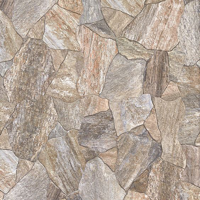

name: block


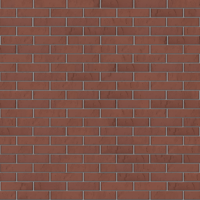

name: squre


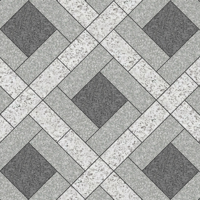

name: textile


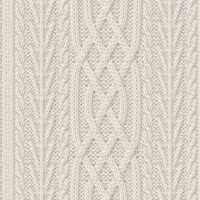

name: roof


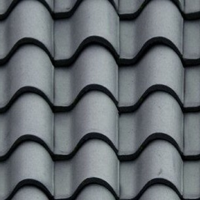

In [2]:
from IPython.display import display

for i, key in enumerate(material_dict.keys(), 1):
    print(f"{i}. {key}")

print("sources:")
for key, data in material_dict.items():
    print(f"name: {key}")
    display(data['image'].copy().resize((200, 200)))

In [3]:
def get_image(material_name):
    return material_dict[material_name]['image'].copy()

def get_pixels(material_name):
    return material_dict[material_name]['pixels']

def get_size(material_name):
    return material_dict[material_name]['image'].size

In [4]:
def show_5x5_patches_improved(image, boundary_coords, num_patches):
    img_array = np.array(image.convert('RGBA'))
    print(f"Image size：{img_array.shape}")

    for i, (y, x) in enumerate(boundary_coords[:num_patches]):
        y = int(round(y))
        x = int(round(x))

        transparent_patch = np.zeros((5, 5, 4), dtype=np.uint8)
        transparent_patch[..., 3] = 0

        y_low = max(0, y - 2)
        y_high = min(img_array.shape[0], y + 3)
        x_low = max(0, x - 2)
        x_high = min(img_array.shape[1], x + 3)

        patch_y_low = max(2 - y, 0)
        patch_y_high = 5 - max(y + 3 - img_array.shape[0], 0)
        patch_x_low = max(2 - x, 0)
        patch_x_high = 5 - max(x + 3 - img_array.shape[1], 0)

        if patch_y_high > patch_y_low and patch_x_high > patch_x_low:
            img_region = img_array[y_low:y_high, x_low:x_high]
            transparent_patch[patch_y_low:patch_y_high,
                              patch_x_low:patch_x_high] = img_region

        print(f"Patch {i+1} at ({y}, {x}) - Shape: {transparent_patch.shape}")
        patch_img = Image.fromarray(transparent_patch, 'RGBA')
        display(patch_img.resize((100, 100), Image.NEAREST))

In [5]:
def show_5x5_single_improved(image, coords):
    img_array = np.array(image.convert('RGBA'))
    print(f"size：{img_array.shape}")

    y, x = coords
    transparent_patch = np.zeros((5, 5, 4), dtype=np.uint8)
    transparent_patch[..., 3] = 0

    y_low = max(0, y - 2)
    y_high = min(img_array.shape[0], y + 3)
    x_low = max(0, x - 2)
    x_high = min(img_array.shape[1], x + 3)

    patch_y_low = max(2 - y, 0)
    patch_y_high = 5 - max(y + 3 - img_array.shape[0], 0)
    patch_x_low = max(2 - x, 0)
    patch_x_high = 5 - max(x + 3 - img_array.shape[1], 0)

    if patch_y_high > patch_y_low and patch_x_high > patch_x_low:
        img_region = img_array[y_low:y_high, x_low:x_high]
        transparent_patch[patch_y_low:patch_y_high,
                              patch_x_low:patch_x_high] = img_region

    print(f"Patch {i+1} at ({y}, {x}) - Shape: {transparent_patch.shape}")
    patch_img = Image.fromarray(transparent_patch, 'RGBA')
    display(patch_img.resize((100, 100), Image.NEAREST))

In [6]:
def matrix_differences_weight_sum(A, B, C):
    A = A.astype(np.float32)
    B = B.astype(np.float32)
    squared_diff = (A - B) ** 2


    weighted_diff = squared_diff * C[:, :, np.newaxis]
    return np.sum(weighted_diff)

In [7]:
def gaussian_kernel(kernel_size=5, sigma=1.0):

    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)

    return kernel

In [8]:
def create_and_display_image(array, size=(300, 300)):
    if array.dtype != np.uint8:
        if array.max() <= 1.0:
            array = (array * 255).astype(np.uint8)
        else:
            array = array.astype(np.uint8)

    img = Image.fromarray(array)
    display(img.resize(size, Image.NEAREST))

def display_array(array, size=(300, 300)):
    img = Image.fromarray(array.astype(np.uint8))
    display(img.resize(size, Image.NEAREST))

In [9]:
'''def find_border_zeros(mask, A):
    cross = np.array([[0, 1, 0],
                      [1, 1, 1],
                      [0, 1, 0]], dtype=bool)

    dilated = binary_dilation(mask, structure=cross)

    border_zeros = (mask == 0) & dilated

    kernel = np.ones((A, A), dtype=int)

    conv = np.zeros_like(mask, dtype=int)
    half = A // 2
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            i_start = max(0, i - half)
            i_end = min(mask.shape[0], i + half + 1)
            j_start = max(0, j - half)
            j_end = min(mask.shape[1], j + half + 1)
            conv[i, j] = np.sum(mask[i_start:i_end, j_start:j_end])

    y_coords, x_coords = np.where(border_zeros)
    counts = conv[border_zeros]

    # sort
    sorted_indices = np.argsort(counts)[::-1]
    sorted_coords = [(y_coords[i], x_coords[i]) for i in sorted_indices]

    return sorted_coords'''
def find_border_zeros(mask, A=1):

    cross = np.array([[0, 1, 0],
                      [1, 1, 1],
                      [0, 1, 0]], dtype=bool)

    dilated = binary_dilation(mask, structure=cross)
    border_zeros = (mask == 0) & dilated

    coords = np.argwhere(border_zeros)
    return [(y, x) for y, x in coords]

In [10]:
'''def pick_one_to_process(synthesized_image, synthesized_process_mask, boundary_coords, window_size):
    if not boundary_coords:
        return None, None, None

    coord = boundary_coords[0]
    y, x = coord
    half_size = window_size // 2

    #picked_matrix = np.zeros((window_size, window_size, 3), dtype=np.float32)
    picked_matrix = np.zeros((window_size, window_size, 3), dtype=np.uint8)
    picked_mask = np.zeros((window_size, window_size), dtype=np.float32)

    img_height, img_width = synthesized_process_mask.shape

    for i in range(window_size):
        for j in range(window_size):
            img_y = y + (i - half_size)
            img_x = x + (j - half_size)

            # if within boundary
            if 0 <= img_y < img_height and 0 <= img_x < img_width:
                # if available
                if synthesized_process_mask[img_y, img_x] == 1:
                    r, g, b = synthesized_image.getpixel((img_x, img_y))
                    picked_matrix[i, j] = [r, g, b]
                    picked_mask[i, j] = 1.0

    return picked_matrix, picked_mask, coord'''

def pick_one_to_process(synthesized_array, process_mask, boundary_coords, window_size):

    if not boundary_coords:
        return None, None, None

    coord = boundary_coords[0]
    y, x = coord
    half_size = window_size // 2

    y_start = max(0, y - half_size)
    y_end = min(synthesized_array.shape[0], y + half_size + 1)
    x_start = max(0, x - half_size)
    x_end = min(synthesized_array.shape[1], x + half_size + 1)

    window_height = y_end - y_start
    window_width = x_end - x_start
    result_matrix = np.zeros((window_size, window_size, 3), dtype=np.uint8)
    result_mask = np.zeros((window_size, window_size), dtype=np.float32)

    r_y_start = max(half_size - y, 0)
    r_y_end = min(half_size + window_height, window_size)
    r_x_start = max(half_size - x, 0)
    r_x_end = min(half_size + window_width, window_size)

    if window_height > 0 and window_width > 0:
        img_slice = synthesized_array[y_start:y_end, x_start:x_end]
        result_matrix[r_y_start:r_y_end, r_x_start:r_x_end] = img_slice

        mask_slice = process_mask[y_start:y_end, x_start:x_end]
        result_mask[r_y_start:r_y_end, r_x_start:r_x_end] = mask_slice

    return result_matrix, result_mask, coord

In [11]:
'''def search_in_source(source_image, picked_matrix, picked_mask, window_size, gaussian_mask, num_candidates=1):
    source_img_array = np.array(source_image)
    height, width, _ = source_img_array.shape
    half_size = window_size // 2

    total_weight = np.sum(gaussian_mask * picked_mask)

    candidates = []

    for y in range(half_size, height - half_size):
        for x in range(half_size, width - half_size):
            window = source_img_array[
                y - half_size:y + half_size + 1,
                x - half_size:x + half_size + 1
            ]

            diff = matrix_differences_weight_sum(
                picked_matrix,
                window,
                gaussian_mask * picked_mask
            ) / total_weight

            candidates.append((diff, (x, y)))


    candidates.sort(key=lambda x: x[0])
    return [pos for _, pos in candidates[:num_candidates]], candidates[0][0]'''

def search_in_source(source_array, picked_matrix, picked_mask, window_size, gaussian_mask, num_candidates=1):
    H, W, _ = source_array.shape
    half_size = window_size // 2

    effective_weights = gaussian_mask * picked_mask
    total_weight = np.sum(effective_weights)

    if total_weight <= 0:
        return [], float('inf')

    differences = np.full((H, W), float('inf'), dtype=np.float32)

    y_indices = np.arange(half_size, H - half_size)
    x_indices = np.arange(half_size, W - half_size)
    y_grid, x_grid = np.meshgrid(y_indices, x_indices, indexing='ij')

    for y, x in zip(y_grid.ravel(), x_grid.ravel()):
        window = source_array[y - half_size:y + half_size + 1,
                              x - half_size:x + half_size + 1]

        diff = matrix_differences_weight_sum(
            picked_matrix, window, effective_weights
        ) / total_weight

        differences[y, x] = diff

    min_y, min_x = np.unravel_index(np.argmin(differences), differences.shape)
    min_diff = differences[min_y, min_x]

    flat_differences = differences.ravel()
    flat_indices = np.argsort(flat_differences)[:num_candidates]
    candidate_positions = [(idx % W, idx // W) for idx in flat_indices]

    return candidate_positions, min_diff

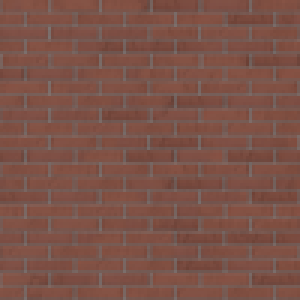

In [13]:
# synthesized texture
synthesized_source = get_image('block')

seed_size = 100,100

synthesized_source = synthesized_source.resize(seed_size)
synthesized_source_size = synthesized_source.size
display(synthesized_source.resize((300, 300), Image.NEAREST))

In [14]:
# matrix setting
window_size = 5
sigma = 2.5

gaussian_mask = gaussian_kernel(window_size, sigma)
print(gaussian_mask)

[[0.02853721 0.0362779  0.03929938 0.0362779  0.02853721]
 [0.0362779  0.04611825 0.0499593  0.04611825 0.0362779 ]
 [0.03929938 0.0499593  0.05412027 0.0499593  0.03929938]
 [0.0362779  0.04611825 0.0499593  0.04611825 0.0362779 ]
 [0.02853721 0.0362779  0.03929938 0.0362779  0.02853721]]


In [15]:
'''# 5*5 of source
synthesized_size = (synthesized_source_size[0]*3,synthesized_source_size[1]*3)
synthesized_frame = (synthesized_size[0] + window_size*2,synthesized_size[1] + window_size*2)
synthesized_image = Image.new('RGB', synthesized_frame, (0, 0, 0))

# paste in middle
paste_position = (synthesized_source_size[0]*1 + window_size, synthesized_source_size[1]*1 + window_size)
synthesized_image.paste(synthesized_source, paste_position)

synthesized_process_mask = np.zeros((synthesized_size[1], synthesized_size[0]), dtype=np.uint8)

# update mask
x_start, y_start = paste_position
x_end = x_start + synthesized_source_size[0]
y_end = y_start + synthesized_source_size[1]
synthesized_process_mask[y_start:y_end, x_start:x_end] = 1
print(synthesized_source_size)
print(synthesized_size)

print(f"size: {synthesized_size}  window size: {window_size}x{window_size}")
display(synthesized_image.resize((300, 300), Image.NEAREST))

synthesized_mask_boundary = find_border_zeros(synthesized_process_mask, window_size)

show_5x5_patches_improved(synthesized_image, synthesized_mask_boundary, num_patches=3)

# test pick_one_to_process
test_matrix, test_mask, test_coord = pick_one_to_process(
    synthesized_image,
    synthesized_process_mask,
    synthesized_mask_boundary,
    window_size
)

print("coord:", test_coord)
print("coord:", synthesized_mask_boundary[0])
print("\nmask:")
print(test_mask)
show_5x5_single_improved(synthesized_image, test_coord)

candidate_positions, min_diff = search_in_source(
                synthesized_source,
                test_matrix,
                test_mask,
                window_size,
                gaussian_mask,
                num_candidates=5
            )

print(f"best: {candidate_positions[0]} | diff: {min_diff}")
print(f"best5: {candidate_positions[:5]}")
show_5x5_single_improved(synthesized_source, candidate_positions[0])
show_5x5_patches_improved(synthesized_source, candidate_positions, num_patches=3)'''

'# 5*5 of source\nsynthesized_size = (synthesized_source_size[0]*3,synthesized_source_size[1]*3)\nsynthesized_frame = (synthesized_size[0] + window_size*2,synthesized_size[1] + window_size*2)\nsynthesized_image = Image.new(\'RGB\', synthesized_frame, (0, 0, 0))\n\n# paste in middle\npaste_position = (synthesized_source_size[0]*1 + window_size, synthesized_source_size[1]*1 + window_size)\nsynthesized_image.paste(synthesized_source, paste_position)\n\nsynthesized_process_mask = np.zeros((synthesized_size[1], synthesized_size[0]), dtype=np.uint8)\n\n# update mask\nx_start, y_start = paste_position\nx_end = x_start + synthesized_source_size[0]\ny_end = y_start + synthesized_source_size[1]\nsynthesized_process_mask[y_start:y_end, x_start:x_end] = 1\nprint(synthesized_source_size)\nprint(synthesized_size)\n\nprint(f"size: {synthesized_size}  window size: {window_size}x{window_size}")\ndisplay(synthesized_image.resize((300, 300), Image.NEAREST))\n\nsynthesized_mask_boundary = find_border_zero

In [16]:
def texture_synthesis(source_image, synthesized_size, window_size=5, max_iterations=100000, sigma=1.5, num_of_RandomSelect=5):

    source_array = np.array(source_image)


    src_h, src_w, _ = source_array.shape
    syn_w, syn_h = synthesized_size
    pad = window_size * 2
    work_shape = (syn_h + pad, syn_w + pad, 3)
    work_array = np.zeros(work_shape, dtype=np.uint8)
    process_mask = np.zeros((syn_h + pad, syn_w + pad), dtype=np.uint8)

    start_y = pad // 2 + src_h
    start_x = pad // 2 + src_w
    work_array[start_y:start_y+src_h, start_x:start_x+src_w] = source_array
    process_mask[start_y:start_y+src_h, start_x:start_x+src_w] = 1

    gaussian_weights = gaussian_kernel(window_size, sigma)

    boundary_queue = list(find_border_zeros(process_mask))

    start_time = time.time()
    iteration = 0
    progress_interval = min(max_iterations // 10, 1000) or 100

    print(f"synthesized size: {synthesized_size} | window: {window_size}x{window_size} | source: {source_image.size}")

    while boundary_queue and iteration < max_iterations:
        print(f"boundary num: {len(boundary_queue)} i: {iteration}")
        while boundary_queue and iteration < max_iterations:
            current_coord = boundary_queue.pop(0)
            y, x = current_coord

            if process_mask[y, x] == 1:
                continue

            picked_matrix, picked_mask, _ = pick_one_to_process(
                work_array, process_mask, [current_coord], window_size)

            candidates, min_diff = search_in_source(
                source_array,
                picked_matrix,
                picked_mask,
                window_size,
                gaussian_weights,
                num_candidates=num_of_RandomSelect
            )

            if candidates:
                best_x, best_y = random.choice(candidates)
                work_array[y, x] = source_array[best_y, best_x]
                process_mask[y, x] = 1

            if iteration % 10000 == 0:
                completed = process_mask.sum() / process_mask.size
                display_time = time.time() - start_time
                print(f"i: {iteration} | process: {completed:.1%} | time: {display_time:.1f}s")
                display(Image.fromarray(work_array))
            iteration += 1

        # refresh detection
        boundary_queue = list(find_border_zeros(process_mask))


    final_img = Image.fromarray(work_array[window_size:-window_size,
                                          window_size:-window_size])

    total_time = time.time() - start_time
    pixels_processed = process_mask.sum()
    print(f"finished used time: {total_time:.1f}s | process pixel: {pixels_processed}")

    display(final_img)
    return final_img


synthesized size: (300, 300) | window: 5x5 | source: (100, 100)
boundary num: 400 i: 0
i: 0 | process: 10.4% | time: 0.1s


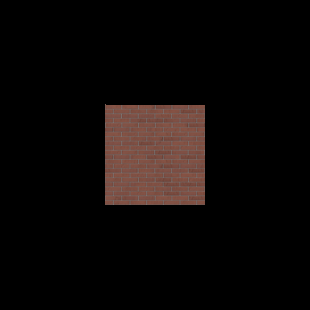

boundary num: 404 i: 400
boundary num: 408 i: 804
boundary num: 412 i: 1212
boundary num: 416 i: 1624
boundary num: 420 i: 2040
boundary num: 424 i: 2460
boundary num: 428 i: 2884
boundary num: 432 i: 3312
boundary num: 436 i: 3744
boundary num: 440 i: 4180
boundary num: 444 i: 4620
boundary num: 448 i: 5064
boundary num: 452 i: 5512
boundary num: 456 i: 5964
boundary num: 460 i: 6420
boundary num: 464 i: 6880
boundary num: 468 i: 7344
boundary num: 472 i: 7812
boundary num: 476 i: 8284
boundary num: 480 i: 8760
boundary num: 484 i: 9240
boundary num: 488 i: 9724
i: 10000 | process: 20.8% | time: 1323.4s


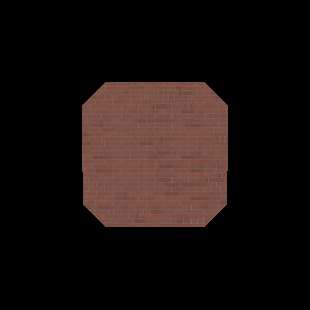

boundary num: 492 i: 10212
boundary num: 496 i: 10704
boundary num: 500 i: 11200
boundary num: 504 i: 11700
boundary num: 508 i: 12204
boundary num: 512 i: 12712
boundary num: 516 i: 13224
boundary num: 520 i: 13740
boundary num: 524 i: 14260
boundary num: 528 i: 14784
boundary num: 532 i: 15312
boundary num: 536 i: 15844
boundary num: 540 i: 16380
boundary num: 544 i: 16920
boundary num: 548 i: 17464
boundary num: 552 i: 18012
boundary num: 556 i: 18564
boundary num: 560 i: 19120
boundary num: 564 i: 19680
i: 20000 | process: 31.2% | time: 2644.9s


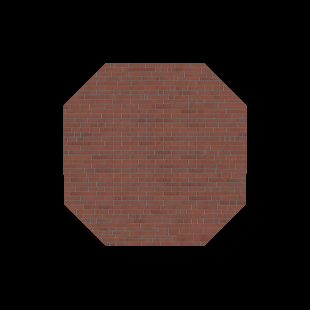

boundary num: 568 i: 20244
boundary num: 572 i: 20812
boundary num: 576 i: 21384
boundary num: 580 i: 21960
boundary num: 584 i: 22540
boundary num: 588 i: 23124


In [ ]:
synthesized_texture = texture_synthesis(
    synthesized_source,
    (300, 300),
    window_size,
    max_iterations=1000000,
    sigma=2.5,
    num_of_RandomSelect=1
)

output_path = '/content/drive/MyDrive/testspeedarraylist.jpg'
synthesized_texture.save(output_path)
print(f"saved at: {output_path}")